In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import mpltern
import polyphase
plt.rcParams.update({"text.usetex": True})

import plotly.graph_objects as go
from plotly.figure_factory import create_trisurf

from scipy.spatial.distance import pdist, euclidean
from itertools import combinations 

In [3]:
systems={0:{'M':[789.266,11.36,1],'chi':[1.88,0.42,1.25]},
        1: {'M':[408.5,11.36,1],'chi':[1.33,0.34,1.25]}
        }
# M -- polymer, small molecule, solvent
# chi -- (p, sm);(p,solv);(solv, sm)
     
KEY = 1

3-dimensional grid generated at 0.29s
Energy computed at 3.35s
Making energy manifold a paraboloid with 2x padding of 0.30 maximum energy
Energy is corrected at 5.39s
Convexhull is computed at 5.41s
Simplices are refined at 5.43s
Total of 246 simplices in the convex hull
Using 5.03E-02 as a threshold for Laplacian of a simplex
Simplices are labelled at 5.56s
Labels are lifted at 6.02s
Total 0/246 coplanar simplices
Computation took 6.03s


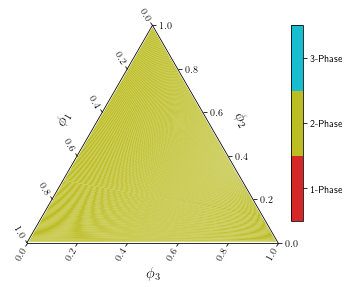

In [4]:
# default version
f = lambda x : polyphase.flory_huggins(x, systems[KEY]['M'], systems[KEY]['chi'])
engine = polyphase.PHASE(f,200, 3)

engine.compute(thresh_scale=10,verbose=True)
engine.plotter()
plt.show()

Computation took 27.17s


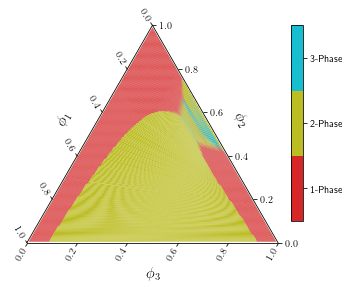

<Figure size 432x288 with 0 Axes>

In [10]:
# Beta correction
betas = np.logspace(-2,-3,num=7)
for beta in betas:
    f = lambda x : polyphase.flory_huggins(x, systems[KEY]['M'], systems[KEY]['chi'], 
                                           beta=beta)
    engine = polyphase.PHASE(f,200, len(systems[KEY]['M']) )

    engine.compute(thresh_scale=10,verbose=False)
    engine.plotter()
    fig = plt.gcf()
    fig.suptitle('beta = {:.2E}'.format(beta))
    plt.show()
    break

In [ ]:
# scaled free enregy to check if there's computational issue
def f_scaled(x,M,chi):
    M_max = max(M)
    M_new = [M_max/M[0], M_max/M[1], M_max/M[2]]
    entropy = M_new[0]*x[0]*np.log(x[0]) + M_new[1]*x[1]*np.log(x[1]) + M_new[2]*x[2]*np.log(x[2])
    enthalpy = M_max*chi[0]*x[0]*x[1] + M_max*chi[1]*x[0]*x[2] + M_max*chi[2]*x[1]*x[2]
    
    return entropy + enthalpy  

f = lambda x : f_scaled(x, systems[KEY]['M'], systems[KEY]['chi'])
engine = polyphase.PHASE(f,200, 3)

engine.compute(thresh_scale=10,verbose=True)
polyphase.plot_mpltern(engine.grid, engine.simplices, engine.num_comps)
plt.show()

In [ ]:
# plotting the pair-wise distances of each simplex
from matplotlib import cm

norm = plt.Normalize(0,1.414)
cmap = cm.viridis

fig, axs = plt.subplots(nrows=1, ncols=3,
                        figsize=(4*3,4),
                        subplot_kw={'projection':'ternary'})
fig.subplots_adjust(wspace=0.5)

for simplex in engine.simplices:
    simplex_points = np.asarray([engine.grid[:,x] for x in simplex])
    dist = pdist(simplex_points,'euclidean')
    
    for i in range(3):
        axs[i].fill(simplex_points[:,2], simplex_points[:,0], simplex_points[:,1],
                   facecolor=cmap(norm(dist[i])))

ticks = [engine.thresh, 0.5,1.414]
for i in range(3):        
    axs[i].set_tlabel(r'$\phi_2$')
    axs[i].set_llabel(r'$\phi_1$')
    axs[i].set_rlabel(r'$\phi_3$')
    axs[i].taxis.set_label_position('tick1')
    axs[i].laxis.set_label_position('tick1')
    axs[i].raxis.set_label_position('tick1')
    
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[i],
                 orientation='horizontal', ticks=ticks, format='%.2f')
    
plt.show()

In [ ]:
# Tests
# 1. Tangent normal test
grad = polyphase.CentralDifference(engine.grid, f)
phase_simplices_ids = np.where(np.asarray(engine.num_comps)==2)[0]
outlist = []
for simplex_id in phase_simplices_ids:
    try:
        test = polyphase.TestAngles(engine,phase=2,simplex_id=simplex_id)
    except RuntimeError:
        pass
    test_out = test.get_angles(grad)
    for _, value in test_out['thetas'].items():
        outlist.append([value[2], value[3]])

outlist = np.asarray(outlist)           
fig, ax = plt.subplots()
ax.hist(outlist[:,1],bins=50, density=False)
ax.set_ylabel('Number of occurances')
ax.set_xlabel('Dot products')
plt.show()

# Phase split test
PHASE_ID = 2
phase_simplices_ids = np.where(np.asarray(engine.num_comps)==PHASE_ID)[0]
failed = []
criteria = engine.df.T['label']==PHASE_ID
lengths = []
for simplex_id in phase_simplices_ids:
    try:
        test = polyphase.TestPhaseSplits(engine,phase=PHASE_ID,simplex_id=simplex_id, threshold=0.05)
        result = test.check_centroid()    
    except RuntimeError:
        result = False
    if not result:    
        failed.append(simplex_id)

print('{}/{} simplices failed the test'.format(len(failed), len(phase_simplices_ids))) 

In [ ]:
# plot a interactive energy landscape
scene = dict(camera= dict(eye=dict(x=1.15, y=1.15, z=0.8)),
             aspectmode='cube', xaxis = dict(title='phi 1'), 
             yaxis = dict(title='phi 2'),
             zaxis = dict(title='energy'))

boundary_points= np.asarray([polyphase.is_boundary_point(x) for x in engine.grid.T])
trace1 = go.Scatter3d(x=engine.grid[0,~boundary_points], y=engine.grid[1,~boundary_points],
                      z=engine.energy[~boundary_points],mode='markers', 
                      marker=dict(size=5,opacity=0.2), name='Energy landscape')
fig_ch = create_trisurf(x=engine.grid[0,:], y=engine.grid[1,:], z=engine.energy, 
                      simplices=engine.simplices)
trace2 = fig_ch['data'][1]
fig = go.Figure(data=[trace1, trace2])
fig['layout']['scene'].update(scene)
a = ','.join('{:.2f}'.format(i) for i in systems[KEY]['M'])
b = ','.join('{:.2f}'.format(i) for i in systems[KEY]['chi'])
ab = 'M : {}\n chi: {}'.format(a,b)

fig['layout']['title'].update(dict(text=ab))
fig.write_html('../figures/notebooks/2.html')

In [ ]:
# Inspecting from CEM to others
M = [1027.3622425960862, 13.205408214909834, 1]
chi = [0.383381, 0.475308, 0.562181]
f = lambda x : polyphase.flory_huggins(x, M, chi)
engine = polyphase.PHASE(f,200, 3)
engine.compute(thresh_scale=10,verbose=True)
polyphase.plot_mpltern(engine.grid, engine.simplices, engine.num_comps)
plt.show()

### Verify if the spinodal range (computed using the equations) is inside the binodal (obtained using the convex hull)

In [ ]:
def Chii(chi):
    chi1 = 0.5*(chi[0]+chi[1]-chi[2])
    chi2 = 0.5*(chi[0]+chi[2]-chi[1])
    chi3 = 0.5*(chi[2]+chi[1]-chi[0])
    
    return [chi1, chi2, chi3]
    
def psi(phi, M, chi):
    psii = []
    chii = Chii(chi)
    for i in range(3):
        psii.append((M[i]*phi[i])/(1-2*chii[i]*M[i]*phi[i]))
        
    return psii

In [ ]:
from matplotlib.cm import ScalarMappable
from matplotlib import colors

M = [64,1,1]
chi = [1,0.3,0.2]


# M = [5,5,1]
# chi = [1,0.5,0.5]

f = lambda x : polyphase.flory_huggins(x, M, chi)
engine = polyphase.PHASE(f,200, 3)
engine.compute(thresh_scale=10)

def plot_mpltern_mit65(engine):
    fig, ax = plt.subplots(subplot_kw={'projection':'ternary'})
    phase_colors =['w','tab:red','tab:olive','tab:cyan']
    cmap = colors.ListedColormap(phase_colors[1:])
    for l,s in zip(engine.num_comps, engine.simplices):
        simplex_points = np.asarray([engine.grid[:,x] for x in s])
        ax.fill(simplex_points[:,0], simplex_points[:,1], simplex_points[:,2], 
                facecolor=phase_colors[int(l)])
        
    ax.set_tlabel(r'$\phi_1$', fontsize=15)
    ax.set_llabel(r'$\phi_2$', fontsize=15)
    ax.set_rlabel(r'$\phi_3$', fontsize=15)

    boundaries = np.linspace(1,4,4)
    norm = colors.BoundaryNorm(boundaries, cmap.N)
    mappable = ScalarMappable(norm=norm, cmap=cmap)
    cax = ax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax.transAxes)
    cbar = fig.colorbar(mappable,shrink=0.5, aspect=5, ticks=[1.5,2.5,3.5],cax=cax)
    cbar.ax.set_yticklabels(['1-Phase', '2-Phase', '3-Phase'])
    
    return ax, cbar 

plot_mpltern_mit65(engine)
plt.show()

In [ ]:
# compute critical point and draw spinodal points
from scipy.optimize import fsolve

def equations(phi, M, chi):
    psii = psi(phi, M, chi)
    chii = Chii(chi)
    
    t1 = sum(psii)
    t2 = 0
    for i in range(3):
        t2 += M[i]*psii[i]*((1+2*chii[i]*psii[i])**2)
    
    t3 = sum(phi)-1
    
    return [t1,t2,t3]

sol,info,ier,msg =  fsolve(equations, [0.5, 0.5, 0], args=(M,chi),full_output=True)
print(sol, info['fvec'])

residuals = np.asarray([equations(x,M,chi) for x in engine.grid.T])
fig, axs = plt.subplots(1,3,figsize=(4*3, 4), subplot_kw={'projection':'ternary'})
fig.subplots_adjust(wspace=0.4)
for i in range(3):
    inrange = np.abs(residuals[:,i])<=1e-3
    im = axs[i].scatter(engine.grid[0,inrange], engine.grid[1,inrange], engine.grid[2,inrange], 
                   c=residuals[inrange,i], cmap='bwr')
    axs[i].set_tlabel(r'$\phi_1$', fontsize=15)
    axs[i].set_llabel(r'$\phi_2$', fontsize=15)
    axs[i].set_rlabel(r'$\phi_3$', fontsize=15)
    
    cax = axs[i].inset_axes([1.05, 0.1, 0.05, 0.9], transform=axs[i].transAxes)
    fig.colorbar(im, cax=cax, pad=0.15)

## Binodal chemical potential based

In [ ]:
class BinodalConditions:
    def __init__(self, engine, m,chi,eps=1e-5):
        self.engine = engine
        self.m = m
        self.chi = chi
        
        self.eps = eps

    def get_chemical_potential(self, phi):
        mu_1 = (phi[1]**2)*chi[0] + (phi[2]**2)*self.chi[1] + \
        phi[2]*(1-(1/self.m) + phi[1]*(self.chi[0]+self.chi[1]-self.chi[2]))+np.log(phi[0])
        
        mu_2 = ((phi[1]-1)**2)*self.chi[0] + (phi[2]**2)*self.chi[1] - phi[2]/self.m + \
        phi[2]*(1+(phi[1]-1)*(self.chi[0]+self.chi[1])+self.chi[2]-(phi[1]*self.chi[2]))+np.log(phi[1])
        
        mu_3 = 1-phi[2]+self.m*(-1 + self.chi[1] + (phi[2]**2)*self.chi[1] + \
                                phi[2]*(1-2*self.chi[1]+phi[1]*(self.chi[0]+self.chi[1]-
                                                                self.chi[2]))) + \
        self.m*phi[1]*((phi[1]-1)*self.chi[0]-self.chi[1]+self.chi[2]) +np.log(phi[2])
        
        return np.asarray([mu_1, mu_2, mu_3])
    
    def _compute_residual(self,val1, val2, scale):
        diff = val1 - val2
#         scale = 1 #Formula 1
        scale = 0.5*(val1+val2)+self.eps # Formula 3
        residual = np.abs(diff/scale)     
        return residual
    
    def get_binodal_conditions(self,phi_1, phi_2):
        self.mu1 = self.get_chemical_potential(phi_1)
        self.mu2 = self.get_chemical_potential(phi_2)

        t1 = self._compute_residual(self.mu1[0], self.mu2[0], -20)
        t2 = self._compute_residual(self.mu1[1], self.mu2[1], -20)
        t3 = self._compute_residual(self.mu1[2], self.mu2[2], -85)

        return np.asarray([t1,t2,t3])
  
    def evaluate_simplex(self, simplex, threshold=1e-3):
        points = np.asarray([self.engine.grid[:,x] for x in simplex])
        indx = list(combinations(range(3),2))
        self.max_edge_verts = indx[np.argmax(pdist(points))]
        self.phi_1 = points[self.max_edge_verts[0],:]
        self.phi_2 = points[self.max_edge_verts[1],:]

        residuals = self.get_binodal_conditions(self.phi_1,self.phi_2)
        flag = (residuals<threshold).all()

        return points, residuals, flag

In [ ]:
PHASE_ID = 2
PHASE_ID_SIMPLICES = engine.simplices[np.asarray(engine.num_comps)==PHASE_ID]
BCTest = BinodalConditions(engine,M[0],chi)

fig, axs = plt.subplots(nrows=1, ncols=3,
                        figsize=(4*3,4),
                        subplot_kw={'projection':'ternary'})
fig.subplots_adjust(wspace=0.5)
failed = []

# norms = [plt.Normalize(0,4.01), plt.Normalize(0,0.664), plt.Normalize(0,12.03)] # Formula 1
# norms = [plt.Normalize(0,0.2), plt.Normalize(0,0.03), plt.Normalize(0,0.14)] # Formula 2
norms = [plt.Normalize(0,1.75), plt.Normalize(0,1.99), plt.Normalize(0,0.27)] # Formula 3

cmap = cm.viridis

residuals = []
for simplex in PHASE_ID_SIMPLICES:
    points, residual, flag = BCTest.evaluate_simplex(simplex, threshold=1e-4)
    residuals.append(residual)
    for i in range(3):
        axs[i].fill(points[:,0], points[:,1], points[:,2],
                    facecolor=cmap(norms[i](residual[i])))
        
for i,ax in enumerate(axs):
    ax.set_tlabel(r'$\phi_1$', fontsize=15)
    ax.set_llabel(r'$\phi_2$', fontsize=15)
    ax.set_rlabel(r'$\phi_3$', fontsize=15)
    cax = ax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax.transAxes)
    fig.colorbar(cm.ScalarMappable(norm=norms[i], cmap=cmap), cax=cax)
plt.show()        

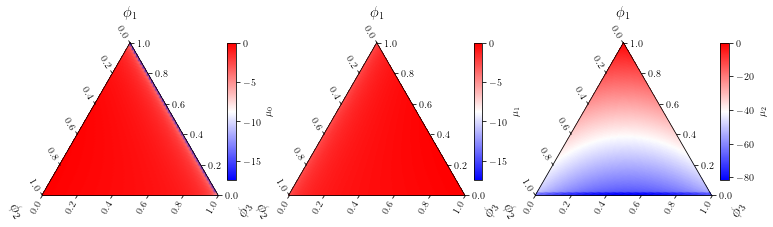

In [20]:
# plot chemical potentials
chempots = np.asarray([chemical_potential(x,M,chi) for x in engine.grid.T])
fig, axs = plt.subplots(1,3,figsize=(4*3, 4), subplot_kw={'projection':'ternary'})
fig.subplots_adjust(wspace=0.4)
for i in range(3):
    im = axs[i].scatter(engine.grid[2,:], engine.grid[0,:], engine.grid[1,:], 
                   c=chempots[:,i], cmap='bwr')
    axs[i].set_tlabel(r'$\phi_1$', fontsize=15)
    axs[i].set_llabel(r'$\phi_2$', fontsize=15)
    axs[i].set_rlabel(r'$\phi_3$', fontsize=15)
    
    cax = axs[i].inset_axes([1.05, 0.1, 0.05, 0.9], transform=axs[i].transAxes)
    cbar = fig.colorbar(im, cax=cax, pad=0.15)
    cbar.set_label(r'$\mu_{}$'.format(i))
    
plt.show()

In [17]:
cp_flags = np.abs(residuals[:,1])<=1e-3
cp_candidates = engine.grid[:,cp_flags]
cp_values = residuals[cp_flags,1]
for cand, value in zip(cp_candidates.T, cp_values):
    print(cand, value)

[0.1557789  0.20100503 0.63819096] -0.0006458411484596693
[0.1557789  0.20100503 0.64321608] -5.175907427718007e-05
[0.1557789  0.20100503 0.64824121] 0.0005295765602764124
[0.14070353 0.25125629 0.60301508] -0.0003293607278327393
[0.14070353 0.25125629 0.6080402 ] 0.00035882496709860323
[0.13065328 0.28643217 0.57788945] -0.0008975767758875319
[0.13065328 0.28643217 0.58291458] -0.0001366277656403847
[0.13065328 0.28643217 0.5879397 ] 0.00060937997520355


Computation took 5.77s


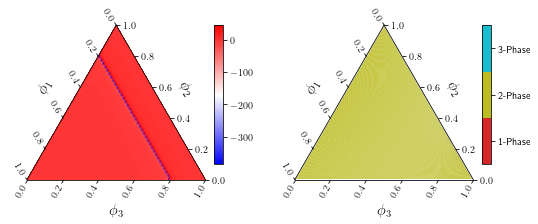

5
Computation took 5.54s


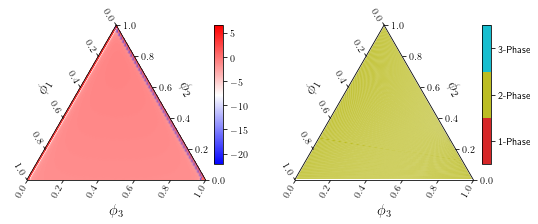

100
Computation took 5.55s


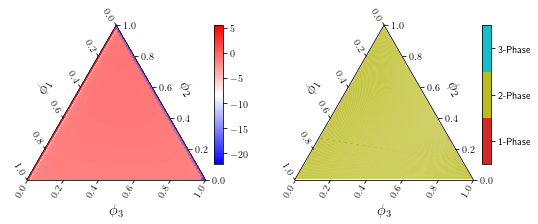

200
Computation took 5.70s


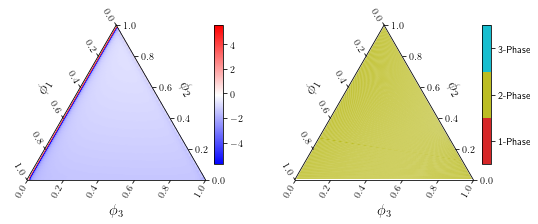

500
Computation took 5.77s


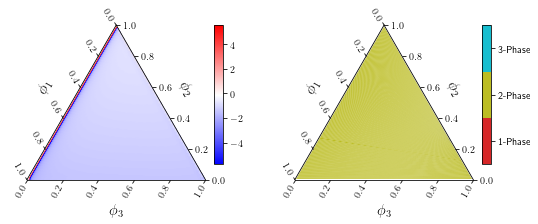

1000


In [20]:
data_type = 'sys1'

for m in [5,100,200,500,1000]:
    
    if data_type=='pm6y6':
        M = [m,13.21,1]
        chi = [0.38,0.48,0.56]
        
    elif data_type=='mit65':
        M = [m,1,1]
        chi = [1,0.3,0.2]
        
    elif data_type=='sys1':
        M = [m,11.36,1]
        chi = [1.88,0.42,1.25]
        
    else:
        raise KeyError('No such data exists...')
    
    f = lambda x : polyphase.flory_huggins(x, M, chi)
    engine = polyphase.PHASE(f,200, 3)
    engine.compute(thresh_scale=10)
    spinodal_condition = [sum(psi(x, M, chi)) for x in engine.grid.T]

    fig, axs = plt.subplots(1,2,figsize=(2*4,4),subplot_kw={'projection':'ternary'})
    fig.subplots_adjust(wspace=0.5)
    im = axs[0].scatter(engine.grid[2,:],engine.grid[0,:],engine.grid[1,:], 
                     c=spinodal_condition, cmap='bwr')
    polyphase._set_axislabels_mpltern(axs[0])
    cax = axs[0].inset_axes([1.05, 0.1, 0.05, 0.9], transform=axs[0].transAxes)
    fig.colorbar(im, cax=cax, pad=0.15)

    polyphase.plot_mpltern(engine.grid, engine.simplices, engine.num_comps,ax=axs[1])
    plt.show()
    print(m)